In [20]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib  # To load your trained model
from sklearn.model_selection import train_test_split
import os

In [2]:
import mlflow

# Set the MLflow tracking URI to the DagsHub repository
mlflow.set_tracking_uri("https://dagshub.com/Omdena/MyanmarChapter_MicroGridOptimization.mlflow")

# The Run ID from the experiment
run_id = '557454fc7e5d4c7d9c962448a1b1a82a'

# Construct the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model using MLflow
model = mlflow.pyfunc.load_model(model_uri)

# Use the loaded model for predictions
# For example, y_pred = model.predict(X_test)


c:\Users\Nino\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:


# List of CSV files
files = [
    'ayeyarwady_Pathein.csv', 'Bago_Bago_pv_weather_merged.csv', 'Hakha_Chin.csv', 
    'Hpa_ay_kayin_pv_weather_data.csv', 'mawlamyine_mon_pv_weather_data .csv', 'merged_kayah_pv_weather_data.csv',
    'merged_magway_pv_weather_data.csv', 'merged_mandalay_pv_weather_data.csv', 'monywa_sagaing_pv_weather_data.csv', 
    'myitkyina_kachin_pv_weather_data.csv', 'sittwe_rakhine_pv_weather_data.csv', 'taungyyi_shan_pv_weather_data.csv'
]

# Ensure the correct data types for your columns
def ensure_correct_types(df):
    # Convert columns that should be float64
    float_columns = ['electricity', 'sunshine_duration (s)', 'shortwave_radiation (W/m²)', 
                'temperature_2m (°C)', 'cloud_cover (%)']
    
    # Ensure columns are in float format
    for col in float_columns:
        df[col] = df[col].astype('float64')
    
    # Safely convert 'shortwave_radiation (W/m²)' to integer
    df['shortwave_radiation (W/m²)'] = df['shortwave_radiation (W/m²)'].round().astype('int64')
    df['cloud_cover (%)'] = df['cloud_cover (%)'].round().astype('int64')
    
    # Safely convert 'is_day ()' to integer
    df['is_day ()'] = df['is_day ()'].round().astype('int64')
    
    # Ensure other integer columns are cast correctly
   
    
    return df


# Ensure that types are set correctly after transformations



# Function to apply transformations (same as above)
def add_lag_features(df, columns, max_lag=24):
    for col in columns:
        for lag in range(1, max_lag+1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

def add_isw_feature(df):
    df['isw'] = df['is_day ()'].apply(lambda x: 1 if x <= 5 else 0)
    return df

def get_season_myanmar(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [6, 7, 8, 9, 10]:
        return 'rainy'
    elif month in [3, 4, 5]:
        return 'Summer'

def add_season_feature(df):
    # Apply the function to get the season based on the month
    df['season'] = df['month'].apply(get_season_myanmar)
    
    # Convert the 'season' column to dummy variables (one-hot encoding)
    df = pd.get_dummies(df, columns=['season'], drop_first=False)
    
    # Ensure the required dummy columns always exist, even if they are missing from the data
    for season in ['season_Summer', 'season_Winter', 'season_rainy']:
        if season not in df.columns:
            df[season] = 0  # Add the missing column with all values as 0
    
    # Convert dummy season columns to integer type
    for col in df.columns:
        if 'season_' in col:
            df[col] = df[col].astype('int')
    
    return df


def add_future_target(df):
    df['electricity_future'] = df['electricity'].shift(-24)  # Future kW shift
    df.dropna(inplace=True)
    return df

def apply_transformations(df):
    columns = ['electricity', 'sunshine_duration (s)', 'shortwave_radiation (W/m²)', 
               'is_day ()', 'temperature_2m (°C)', 'cloud_cover (%)']
    df = add_lag_features(df, columns)
    df = add_isw_feature(df)
    df = add_season_feature(df)
    df = add_future_target(df)
    return df

def prepare_data_for_model(df):
    X = df[['electricity', 'sunshine_duration (s)', 'shortwave_radiation (W/m²)', 'is_day ()', 
            'temperature_2m (°C)', 'cloud_cover (%)', 
            'electricity_lag_1', 'electricity_lag_2', 'sunshine_duration (s)_lag_1', 
            'sunshine_duration (s)_lag_2', 'shortwave_radiation (W/m²)_lag_1', 
            'shortwave_radiation (W/m²)_lag_2', 'is_day ()_lag_1', 'is_day ()_lag_2', 
            'temperature_2m (°C)_lag_1', 'temperature_2m (°C)_lag_2', 
            'cloud_cover (%)_lag_1', 'cloud_cover (%)_lag_2', 
            'season_Summer', 'season_Winter', 'season_rainy', 'isw']]
    y = df['electricity_future']
    return X, y

In [14]:
import os

file_path = r'C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed'
files_in_directory = os.listdir(file_path)

print("Files in directory:", files_in_directory)


Files in directory: ['ayeyarwady_Pathein.csv', 'Bago_Bago_pv_weather_merged.csv', 'Hakha_Chin.csv', 'Hpa_ay_kayin_pv_weather_data.csv', 'mawlamyine_mon_pv_weather_data .csv', 'merged_kayah_pv_weather_data.csv', 'merged_magway_pv_weather_data.csv', 'merged_mandalay_pv_weather_data.csv', 'monywa_sagaing_pv_weather_data.csv', 'myitkyina_kachin_pv_weather_data.csv', 'sittwe_rakhine_pv_weather_data.csv', 'taungyyi_shan_pv_weather_data.csv']


In [15]:
# Use raw string to avoid escape character issues
for file in files:
    file_path = r'C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed'
    full_file_path = os.path.join(file_path, file)
    
    # Print the full file path to debug
    print(f"Attempting to read file: {full_file_path}")
    
    try:
        df = pd.read_csv(full_file_path)
        
        # Rename column 'kW' to 'electricity' if it exists
        if 'kW' in df.columns:
            df = df.rename(columns={'kW': 'electricity'})
        
        # Rest of your processing code...
    
    except FileNotFoundError as e:
        print(f"File not found: {file}. Skipping this file.")


Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\ayeyarwady_Pathein.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\Bago_Bago_pv_weather_merged.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\Hakha_Chin.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\Hpa_ay_kayin_pv_weather_data.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\mawlamyine_mon_pv_weather_data .csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\merged_kayah_pv_weather_data.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\merged_magway_pv_weather_data.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed\merged_mandalay_pv_weather_data.csv
Attempting to read file: C:\Users\Nino\Desktop\My Files\Omdena Project

In [22]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False) 
    r2 = r2_score(y_true, y_pred) # squared=False for RMSE
    return mae, rmse,r2
results = []

# Use raw string to avoid escape character issues
for file in files:
    file_path = r'C:\Users\Nino\Desktop\My Files\Omdena Project\data\processed'  
    # raw string for the path
    df = pd.read_csv(os.path.join(file_path, file))
    if 'kW' in df.columns:
        df = df.rename(columns={'kW': 'electricity'})
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    df['month'] = df['date'].dt.month
    df = ensure_correct_types(df)
    

    df = apply_transformations(df)

    
    # Prepare data for the model
    X, y_true = prepare_data_for_model(df)
    
    # Predict using the model
    y_pred = model.predict(X)
    
    # Calculate metrics
    mae, rmse,r2 = calculate_metrics(y_true, y_pred)
    
    # Store the results
    results.append({
        'file': file,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

# Convert results to DataFrame and display
metrics_df = pd.DataFrame(results)
print(metrics_df)


metrics_df.to_csv('model_metrics_results.csv', index=False)

C:\Users\Nino\AppData\Local\Temp\ipykernel_24748\800518171.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
C:\Users\Nino\AppData\Local\Temp\ipykernel_24748\800518171.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
C:\Users\Nino\AppData\Local\Temp\ipykernel_24748\800518171.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

                                    file       MAE      RMSE        R2
0                 ayeyarwady_Pathein.csv  0.029443  0.057670  0.935830
1        Bago_Bago_pv_weather_merged.csv  0.031025  0.061757  0.931992
2                         Hakha_Chin.csv  0.031118  0.062396  0.935425
3       Hpa_ay_kayin_pv_weather_data.csv  0.030951  0.061545  0.925919
4    mawlamyine_mon_pv_weather_data .csv  0.029053  0.057563  0.931582
5       merged_kayah_pv_weather_data.csv  0.034184  0.068254  0.922672
6      merged_magway_pv_weather_data.csv  0.025924  0.051597  0.955643
7    merged_mandalay_pv_weather_data.csv  0.027127  0.054562  0.949862
8     monywa_sagaing_pv_weather_data.csv  0.030695  0.061957  0.935163
9   myitkyina_kachin_pv_weather_data.csv  0.038417  0.076499  0.904218
10    sittwe_rakhine_pv_weather_data.csv  0.030866  0.060230  0.940885
11     taungyyi_shan_pv_weather_data.csv  0.034584  0.068981  0.924134


c:\Users\Nino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nino\AppData\Local\Temp\ipykernel_24748\800518171.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
C:\Users\Nino\AppData\Local\Temp\ipykernel_24748\800518171.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

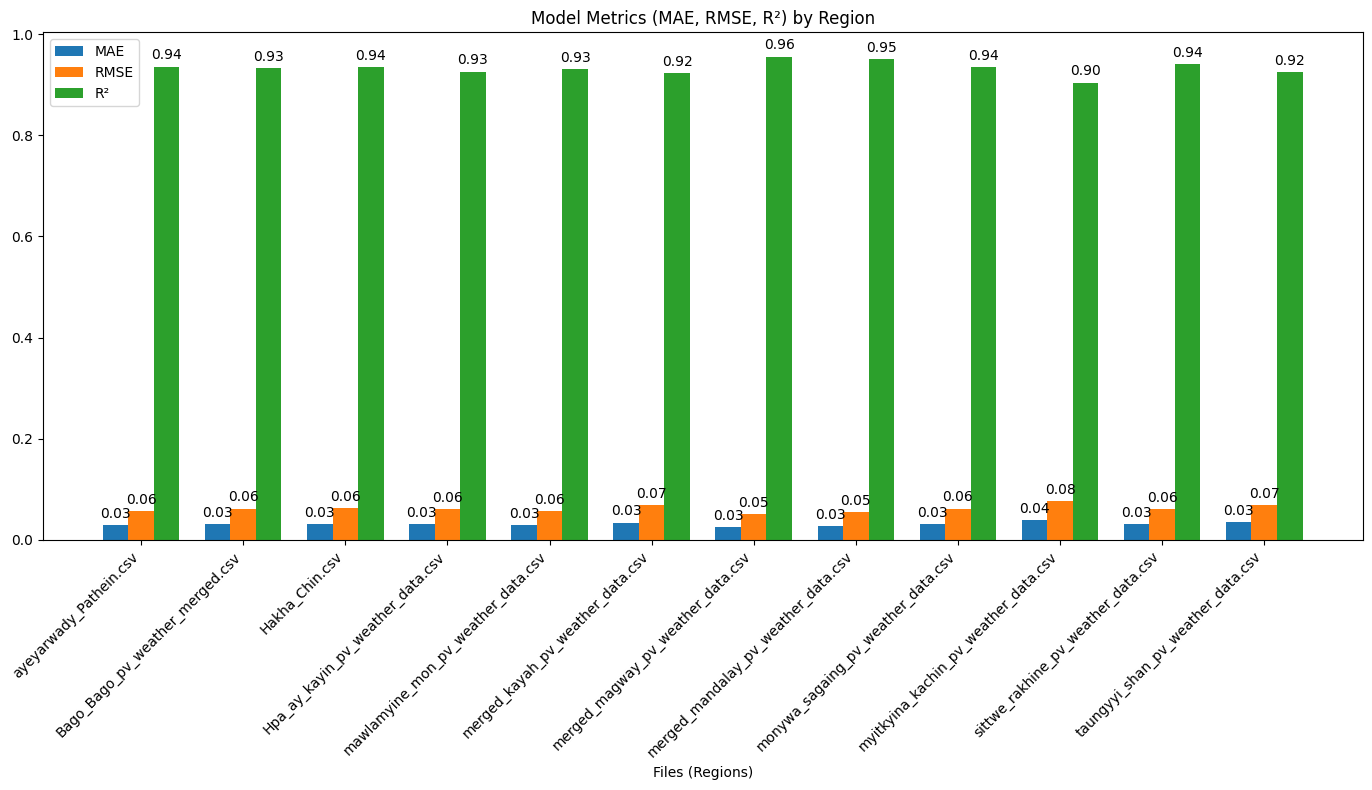

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your data (model metrics)
data = {
    'file': [
        'ayeyarwady_Pathein.csv', 'Bago_Bago_pv_weather_merged.csv', 
        'Hakha_Chin.csv', 'Hpa_ay_kayin_pv_weather_data.csv', 
        'mawlamyine_mon_pv_weather_data.csv', 'merged_kayah_pv_weather_data.csv',
        'merged_magway_pv_weather_data.csv', 'merged_mandalay_pv_weather_data.csv',
        'monywa_sagaing_pv_weather_data.csv', 'myitkyina_kachin_pv_weather_data.csv',
        'sittwe_rakhine_pv_weather_data.csv', 'taungyyi_shan_pv_weather_data.csv'
    ],
    'MAE': [0.029443, 0.031025, 0.031118, 0.030951, 0.029053, 0.034184, 0.025924, 0.027127, 0.030695, 0.038417, 0.030866, 0.034584],
    'RMSE': [0.057670, 0.061757, 0.062396, 0.061545, 0.057563, 0.068254, 0.051597, 0.054562, 0.061957, 0.076499, 0.060230, 0.068981],
    'R2': [0.935830, 0.931992, 0.935425, 0.925919, 0.931582, 0.922672, 0.955643, 0.949862, 0.935163, 0.904218, 0.940885, 0.924134]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Set the positions and width for the bars
x = np.arange(len(df['file']))  # the label locations
width = 0.25  # the width of the bars

# Create a subplot
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting each metric as a bar chart
rects1 = ax.bar(x - width, df['MAE'], width, label='MAE')
rects2 = ax.bar(x, df['RMSE'], width, label='RMSE')
rects3 = ax.bar(x + width, df['R2'], width, label='R²')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Files (Regions)')
ax.set_title('Model Metrics (MAE, RMSE, R²) by Region')
ax.set_xticks(x)
ax.set_xticklabels(df['file'], rotation=45, ha='right')
ax.legend()

# Function to add labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Adjust the layout to prevent clipping of tick-labels
fig.tight_layout()

# Show the plot
plt.show()
